In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import torch

from torchvision.models import *
from visualisation.core.utils import device
from torch import nn

model = alexnet(pretrained=True).to(device)

In [37]:
feature_extractor = nn.Sequential(*list(model.classifier.children())[:-1])

In [38]:
model.classifier = feature_extractor
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [39]:
# %matplotlib notebook 

In [40]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch 
from utils import *
from PIL import Image

plt.rcParams["figure.figsize"]= 16,8

In [41]:
import glob
import matplotlib.pyplot as plt
import numpy as np

from visualisation.core.utils import device 
from PIL import Image

# Path yo your database images. E.g. validation set of ImageNet
image_paths = glob.glob('your_path/*.*') # Change to your dataset path

images = list()
for image_path in image_paths:
    img = Image.open(image_path)
    images.append(img)
    img.load()


In [42]:
from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
from visualisation.core import *
from visualisation.core.utils import image_net_preprocessing

inputs  = [Compose([Resize((224,224)), ToTensor(), image_net_preprocessing])(x).unsqueeze(0) for x in images]  # add 1 dim for batch
inputs = [i.to(device) for i in inputs]

In [43]:
def free(modules):
    for m in modules:
        del m
    torch.cuda.empty_cache()

In [44]:
imagenet2human = {}

with open('imaganet2human.txt') as f:
    for line in f.readlines():
        key, value = line.split(':')
        key = key.replace('{', '').replace('}', '') # I forget how regex works :) 
        value = value.replace("'", '').replace(",", '')
        imagenet2human[int(key.strip())] = str(value.strip())
        
list(imagenet2human.items())[:2]

[(0, 'tench Tinca tinca'), (1, 'goldfish Carassius auratus')]

In [45]:
feature_vectors = list()
for input in inputs:
    feature_vector = model(input)
    feature_vectors.append(feature_vector)

feature_vectors_dict = dict(zip(image_paths, feature_vectors))

In [46]:
# Path to your test image
test_image_path = 'path_to_your_test_image'
test_image = Image.open(test_image_path)
fig = plt.figure()
plt.imshow(test_image)

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_test_image'

In [47]:
processed_test_image  = Compose([Resize((224,224)), ToTensor(), image_net_preprocessing])(test_image).unsqueeze(0)  # add 1 dim for batch

In [31]:
# Forward-propagate to get the embedding
embedding = model(processed_test_image.to(device))

torch.Size([1, 4096])
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ReluBackward1>)


In [32]:
def pdist(sample_1, sample_2, norm=2, eps=1e-5):
    r"""Compute the matrix of all squared pairwise distances.
    Arguments
    ---------
    sample_1 : torch.Tensor or Variable
        The first sample, should be of shape ``(n_1, d)``.
    sample_2 : torch.Tensor or Variable
        The second sample, should be of shape ``(n_2, d)``.
    norm : float
        The l_p norm to be used.
    Returns
    -------
    torch.Tensor or Variable
        Matrix of shape (n_1, n_2). The [i, j]-th entry is equal to
        ``|| sample_1[i, :] - sample_2[j, :] ||_p``."""
    n_1, n_2 = sample_1.size(0), sample_2.size(0)
    norm = float(norm)
    if norm == 2.:
        norms_1 = torch.sum(sample_1**2, dim=1, keepdim=True)
        norms_2 = torch.sum(sample_2**2, dim=1, keepdim=True)
        norms = (norms_1.expand(n_1, n_2) +
                 norms_2.transpose(0, 1).expand(n_1, n_2))
        distances_squared = norms - 2 * sample_1.mm(sample_2.t())
        return torch.sqrt(eps + torch.abs(distances_squared))
    else:
        dim = sample_1.size(1)
        expanded_1 = sample_1.unsqueeze(1).expand(n_1, n_2, dim)
        expanded_2 = sample_2.unsqueeze(0).expand(n_1, n_2, dim)
        differences = torch.abs(expanded_1 - expanded_2) ** norm
        inner = torch.sum(differences, dim=2, keepdim=False)
        return (eps + inner) ** (1. / norm)

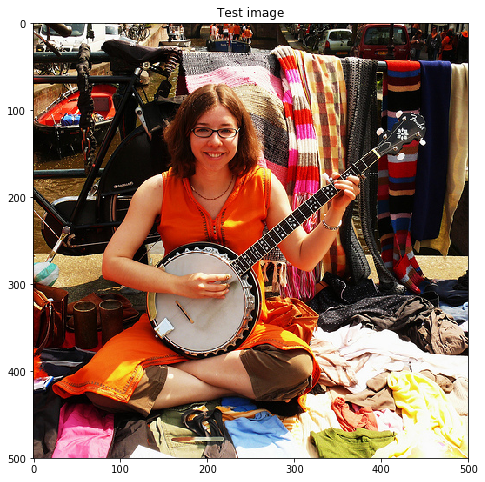

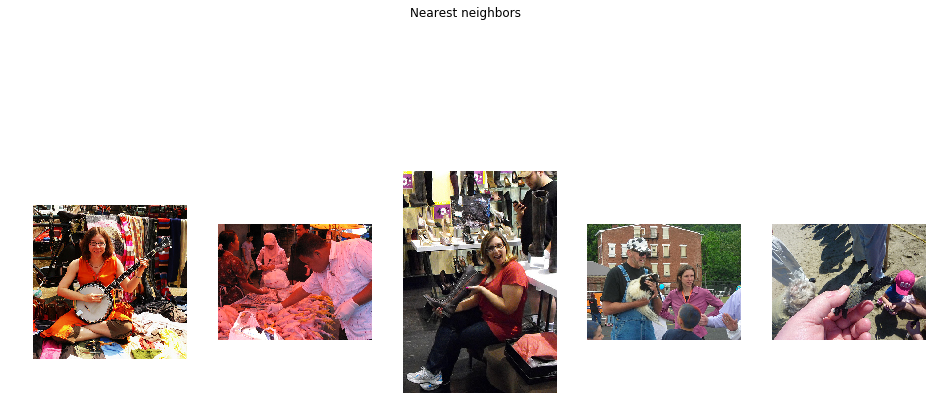

In [34]:
from operator import itemgetter
distance_dict = dict()
neighbors = list()
K = 5 # Change to your expected number of nearest neighbors

for key, feature_vector in feature_vectors_dict.items():
    distance_dict[key] = pdist(embedding, feature_vector) # Compute distance between 2 vectors

test_image = Image.open(test_image_path)
fig = plt.figure()
plt.title('Test image')
plt.imshow(test_image)

res = dict(sorted(distance_dict.items(), key = itemgetter(1))[:K]) 
for similar_image in res.keys():
    neighbors.append(Image.open(similar_image))
    
subplot(neighbors, title='Nearest neighbors', nrows=1, ncols=K)